# Wind Turbine Suitability Prediction Model

### Exploratory Data Analysis and Pre-processing
- Load dataset
- Look for null values and perform data imputation
- Visualize relationships between pairs of features
- Visualize correlation heatmap
- Select features for modelling

In [1]:
# Load labelled_mesonet_data CSVs from batch folders into single dataframe

import pandas as pd
from pathlib import Path

labeled_data_dir = Path('data/labeled_mesonet_data')
batch_folders = sorted(labeled_data_dir.glob('batch_*'))

all_dfs = []
for batch_folder in batch_folders:
    for csv_file in batch_folder.glob('*_measurements.csv'):
        df = pd.read_csv(csv_file)
        all_dfs.append(df)

df_combined = pd.concat(all_dfs, ignore_index=True)

print(f"Loaded {len(all_dfs)} CSV files from {len(batch_folders)} batches")
print(f"\nDataframe shape (rows, columns): {df_combined.shape}")
print(f"\nAll columns: {df_combined.columns.tolist()}")

Loaded 2741 CSV files from 28 batches

Dataframe shape (rows, columns): (1025763, 30)

All columns: ['time', 'airTemperature', 'avgGlobalSolarRadiation', 'barometricPressure', 'cumulativeGlobalSolarRadiation', 'dewPointTemperature', 'fireWeatherIndex', 'heatIndex', 'mslp', 'precipitation', 'precipitationRate', 'rainfall', 'reflectedShortwaveRadiation', 'relativeHumidity', 'seaSurfaceTemperature', 'seaSurfaceTemperature1m', 'snowDepth', 'snowfall', 'visibility', 'waveDirection', 'waveHeight', 'waveHeightMax', 'wetBulbTemperature', 'windChill', 'windDirection', 'windGust', 'windGust10m', 'windSpeed', 'windSpeed10m', 'TurbineScore']


In [2]:
# Remove rows that are largely null (except for 'time' and 'TurbineScore' columns)

df_combined.dropna(how='all', subset=df_combined.columns.difference(['time', 'TurbineScore']), inplace=True)
print(f"\nDataframe shape after dropping largely null rows: {df_combined.shape}")


Dataframe shape after dropping largely null rows: (858618, 30)


In [3]:
# Get statistics and null value counts

display(df_combined.describe()) # Display basic statistics

# Column null counts
null_counts = df_combined.isnull().sum().sort_values(ascending=False)
print(f'\nNull value counts per column: \n{null_counts}')

# Number of rows with no null columns
num_complete_rows = df_combined.dropna().shape[0]
print(f'\nNumber of complete rows (no nulls): {num_complete_rows}')

,airTemperature,avgGlobalSolarRadiation,barometricPressure,cumulativeGlobalSolarRadiation,dewPointTemperature,fireWeatherIndex,heatIndex,mslp,precipitation,precipitationRate,...,waveHeight,waveHeightMax,wetBulbTemperature,windChill,windDirection,windGust,windGust10m,windSpeed,windSpeed10m,TurbineScore
count,811000.000000,6.303300e+04,4.026130e+05,16322.000000,729534.000000,54743.000000,223.000000,398271.000000,4.223820e+05,26231.000000,...,12862.000000,8558.000000,182242.000000,225.000000,674327.000000,9.986500e+04,5.323690e+05,1.448070e+05,7.005970e+05,858618.000000
mean,4.749284,-1.915557e+27,-7.737897e+25,741.479261,-0.466643,8.496059,9.080835,1015.388914,-3.961043e+25,0.101072,...,0.666042,1.786956,5.602005,5.247004,193.907188,-6.114396e+26,-1.362232e+26,-1.262156e+26,-3.098355e+25,0.357223
std,12.254847,1.736563e+29,4.909835e+28,457.151084,11.665375,8.856817,9.856910,11.619719,2.190073e+28,0.362739,...,0.594322,1.719636,10.238480,11.863144,66.270606,1.805581e+29,9.287835e+28,4.802943e+28,2.593373e+28,0.479182
min,-55.283130,-1.678201e+31,-3.115378e+31,0.000000,-97.741667,0.000000,-18.925000,778.837500,-1.396151e+31,0.000000,...,0.000000,0.000000,-55.349179,-30.383333,-67.333333,-5.690757e+31,-6.758760e+31,-1.827688e+31,-2.170697e+31,0.000000
25%,-2.472728,1.088542e+02,9.560958e+02,379.156598,-6.703044,0.807458,4.991667,1009.797222,0.000000e+00,0.000000,...,0.200000,0.500000,0.545087,1.527273,148.291667,8.941500e+00,1.197119e+01,3.717391e+00,4.769444e+00,0.000000
50%,6.675000,1.821071e+02,9.865375e+02,704.586373,1.373556,5.925696,11.550000,1015.587500,1.842105e-02,0.000000,...,0.541667,1.237500,7.762149,8.057895,195.333333,1.363636e+01,1.797083e+01,6.616667e+00,8.206122e+00,0.000000
75%,14.475060,2.603208e+02,1.005250e+03,1053.185032,8.218109,13.500000,15.597143,1021.241667,2.883651e-01,0.027917,...,1.000000,2.516667,12.996013,12.540000,242.791667,2.056667e+01,2.770000e+01,1.171250e+01,1.338333e+01,1.000000
max,391.183333,8.287321e+23,7.145204e+03,3151.720000,45.444737,86.500000,26.233333,1130.350000,8.287321e+23,15.988889,...,6.833333,16.966667,31.725000,24.166667,423.384615,1.317000e+02,9.882125e+02,5.764608e+12,6.846470e+12,1.000000



Null value counts per column: 
heatIndex                         858395
windChill                         858393
reflectedShortwaveRadiation       858354
seaSurfaceTemperature1m           857986
waveDirection                     851959
seaSurfaceTemperature             850836
waveHeightMax                     850060
waveHeight                        845756
snowfall                          842990
cumulativeGlobalSolarRadiation    842296
precipitationRate                 832387
fireWeatherIndex                  803875
avgGlobalSolarRadiation           795585
windGust                          758753
snowDepth                         755144
visibility                        755045
windSpeed                         713811
wetBulbTemperature                676376
rainfall                          575027
mslp                              460347
barometricPressure                456005
precipitation                     436236
windGust10m                       326249
windDirection            

In [4]:
# Take columns with the least null value counts for further analysis and compare dataset size for different null count thresholds

selected_columns = [
    'mslp',
    'barometricPressure',
    'windDirection',
    'windSpeed10m',
    'relativeHumidity',
    'dewPointTemperature',
    'airTemperature',
    'TurbineScore'
]
df_selected = df_combined[selected_columns].copy()

# Number of rows with no/<2/<3 null values in selected columns
num_complete_selected_rows = df_selected.dropna().shape[0]
print(f'\nNumber of complete rows in selected columns: {num_complete_selected_rows}')

num_rows_at_most_1_null = df_selected[df_selected.isnull().sum(axis=1) <= 1].shape[0]
print(f'Number of rows with at most 1 null value in selected columns: {num_rows_at_most_1_null}')


Number of complete rows in selected columns: 368320
Number of rows with at most 1 null value in selected columns: 379036


In [5]:
# Perform data imputation on null values (median)

for column in selected_columns:
    if column != 'TurbineScore':
        median_value = df_selected[column].median()
        df_selected[column] = df_selected[column].fillna(median_value)

df_selected.head()

,mslp,barometricPressure,windDirection,windSpeed10m,relativeHumidity,dewPointTemperature,airTemperature,TurbineScore
13,1013.000000,960.428571,226.285714,0.575397,97.428571,-0.142857,0.214286,0
14,1011.465000,958.952381,105.142857,1.558201,93.523810,-1.142857,-0.142857,0
15,996.605000,945.000000,100.400000,3.050000,93.500000,1.000000,2.045000,0
16,1011.122222,958.863636,84.727273,1.883838,93.909091,3.045455,3.945455,0
17,1009.285714,957.238095,94.571429,2.463757,97.000000,2.714286,3.190476,0


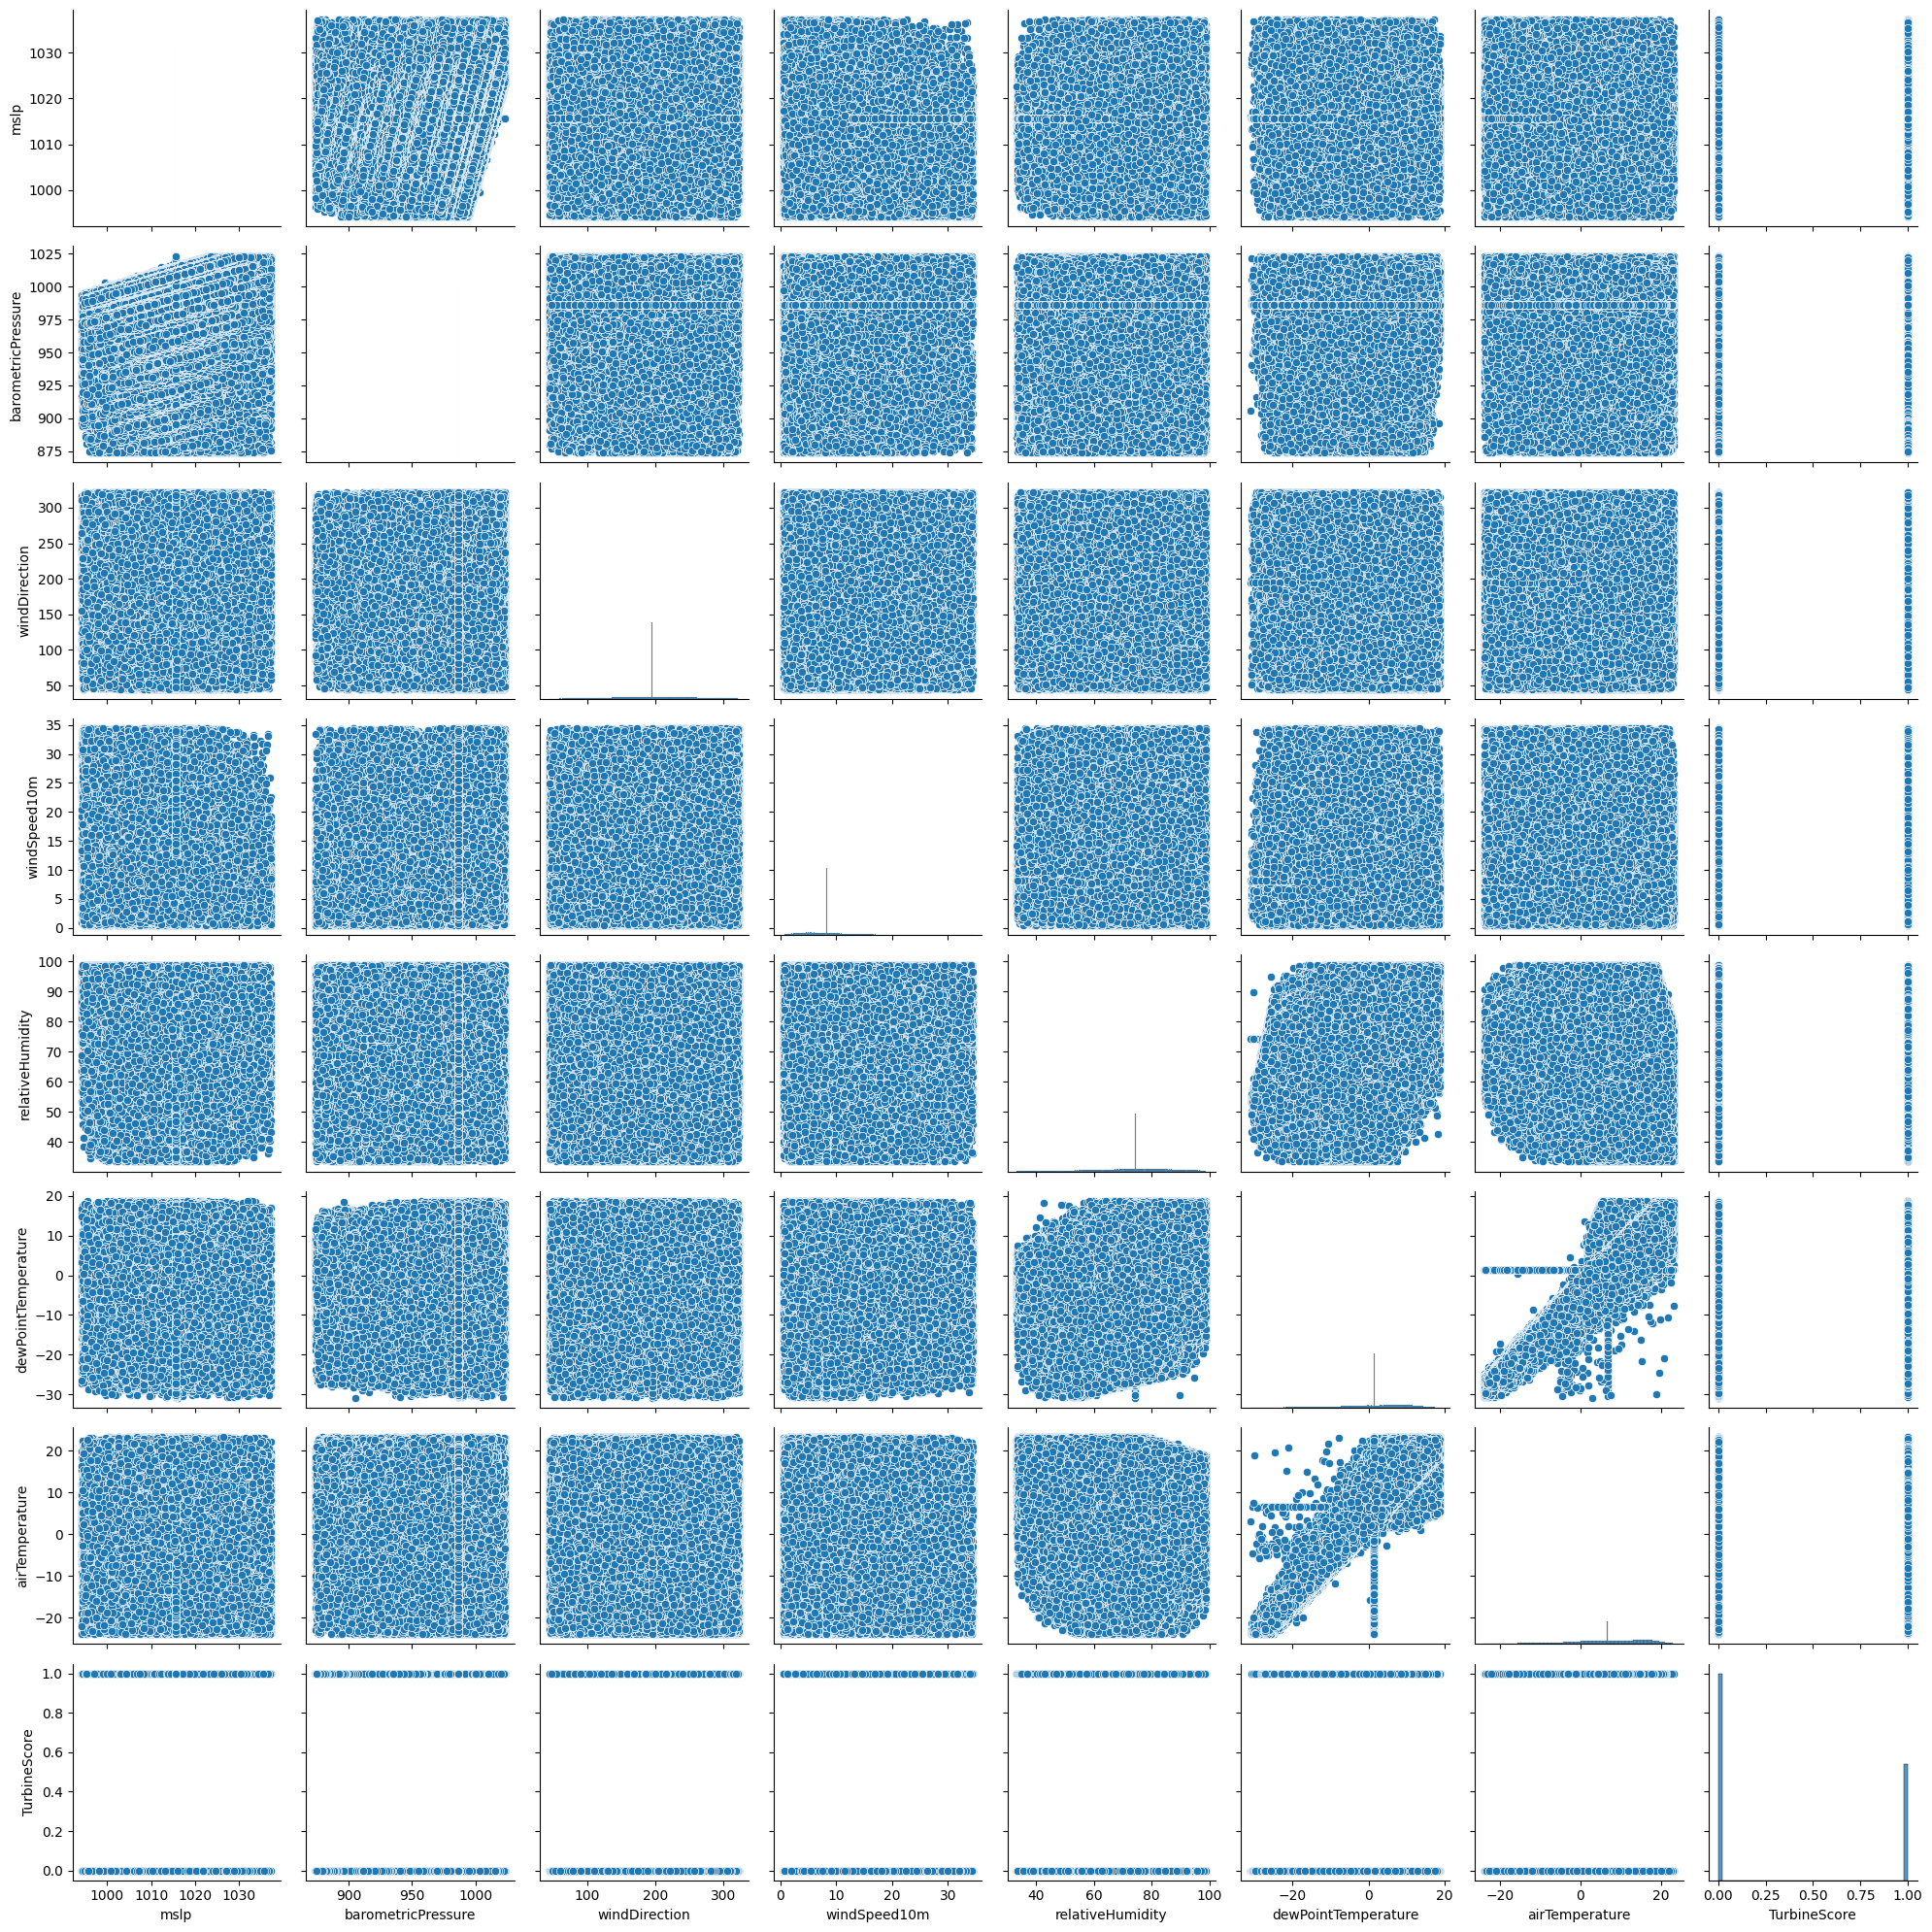

In [6]:
# Remove outliers (using percentile-based filtering) and visualize relationships between features

import matplotlib.pyplot as plt
import seaborn as sns

for column in selected_columns:
    if column != 'TurbineScore':
        lower_bound = df_selected[column].quantile(0.01)
        upper_bound = df_selected[column].quantile(0.99)
        df_selected = df_selected[(df_selected[column] >= lower_bound) & (df_selected[column] <= upper_bound)]

sns.pairplot(df_selected, height=2.5)
plt.tight_layout()
plt.show()

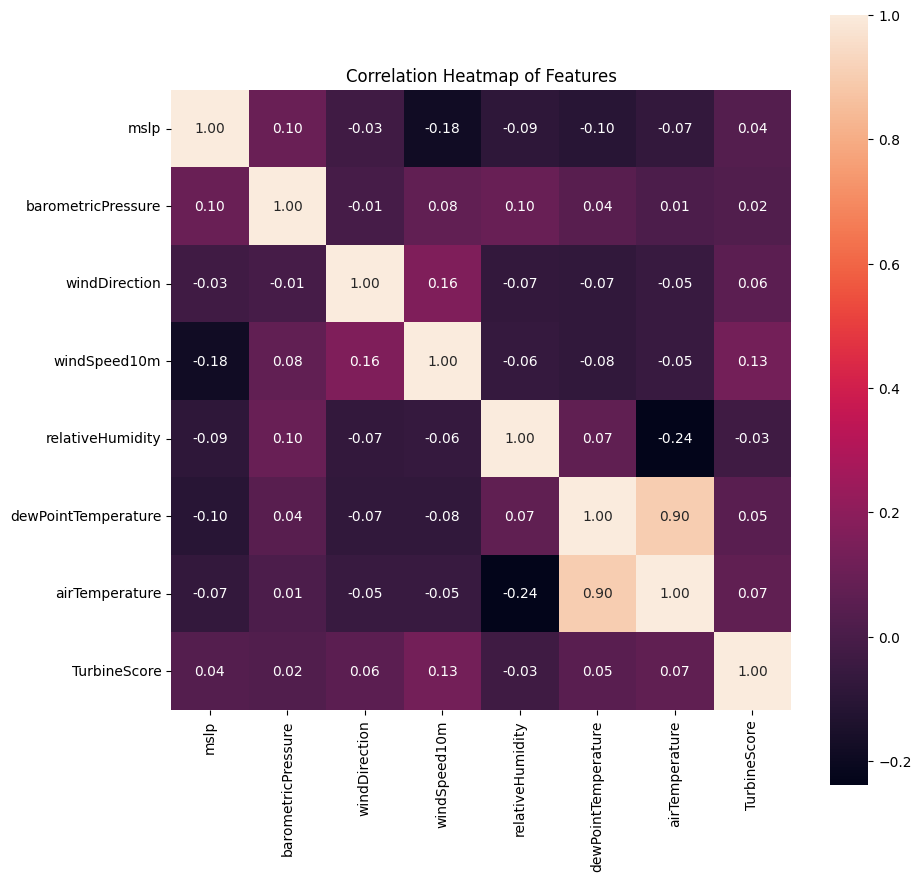

In [7]:
# Visualize correlation heatmap

correlation_matrix = df_selected.corr()
plt.figure(figsize=(10, 10))
hm = sns.heatmap(correlation_matrix, cbar=True,annot=True,
                 square=True, fmt='.2f',
                 yticklabels=correlation_matrix.columns,
                 xticklabels=correlation_matrix.columns)

plt.title("Correlation Heatmap of Features")
plt.show()

## Model Exploration

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score, log_loss
import matplotlib.pyplot as plt
import time

X = df_selected[selected_columns[:-1]]
y = df_selected['TurbineScore']

# (For neural network, X_train and y_train will be split into training and validation sets)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

def train_model(model, X_train, y_train, X_val=None, y_val=None):
    ''' Helper function to train the model and return the time taken '''

    start_time = time.time()
    
    train_losses = []
    val_losses = []
    
    # Check if the classifier supports iterative training (warm_start=True)
    classifier = model.named_steps['classifier']
    if hasattr(classifier, 'warm_start') and classifier.warm_start:
        for i in range(10):
            model.fit(X_train, y_train)
            
            # Training loss
            if hasattr(model, 'loss_'):
                train_losses.append(model.loss_)
            
            # Validation loss
            if hasattr(model, 'predict_proba'):
                y_val_pred_proba = model.predict_proba(X_val)
                val_loss = log_loss(y_val, y_val_pred_proba)
                val_losses.append(val_loss)

    else:
        model.fit(X_train, y_train)
        
    train_time = (time.time() - start_time) * 1000 # (Converting to ms)
    return train_time, train_losses, val_losses


def test_model(model, model_name):
    ''' Helper function to test the model and return time taken '''

    start_time = time.time()
    y_test_pred = model.predict(X_test)
    test_time = (time.time() - start_time) * 1000
    
    # Reporting metrics of predictions (for Q2.1)
    print(f"\n--- {model_name} PREDICTION RESULTS ---")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
    print("F1 Score: ", f1_score(y_test, y_test_pred))
    print("Recall: ", recall_score(y_test, y_test_pred))
    print("Precision: ", precision_score(y_test, y_test_pred))
    print("Accuracy: ", accuracy_score(y_test, y_test_pred))

    # Plotting ROC curve and reporting AUC of predictions (for Q2.2)
    y_test_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    roc_auc = roc_auc_score(y_test, y_test_prob)
    
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.show()
        
    return test_time

### SVM

[LibLinear]

c:\Users\david\GitHub\ds3000a-project-group10\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM TRAINING TIME: 385369.51 ms

--- SVM PREDICTION RESULTS ---
Confusion Matrix:
 [[47232   509]
 [25725  1081]]
F1 Score:  0.07613748415269757
Recall:  0.040326792509139744
Precision:  0.679874213836478
Accuracy:  0.6480877835459509


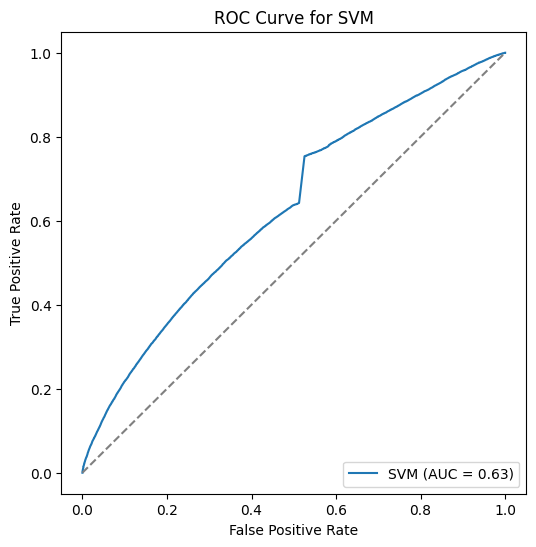

SVM TESTING TIME: 138.28 ms


In [ ]:
svm_model = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3)),
    ('scale', StandardScaler()),
    ('svm', SVC(kernel='rbf', gamma='scale', verbose=True)) 
    ])

svm_train_time, _, _ = train_model(svm_model, X_train, y_train)
print(f"SVM TRAINING TIME: {svm_train_time:.2f} ms")

svm_test_time = test_model(svm_model, "SVM")
print(f"SVM TESTING TIME: {svm_test_time:.2f} ms")

### KNN

KNN TRAINING TIME: 1089.09 ms

--- KNN PREDICTION RESULTS ---
Confusion Matrix:
 [[37917  9824]
 [12262 14544]]
F1 Score:  0.5684136475553992
Recall:  0.5425650973662612
Precision:  0.5968483256730138
Accuracy:  0.7037305324157914


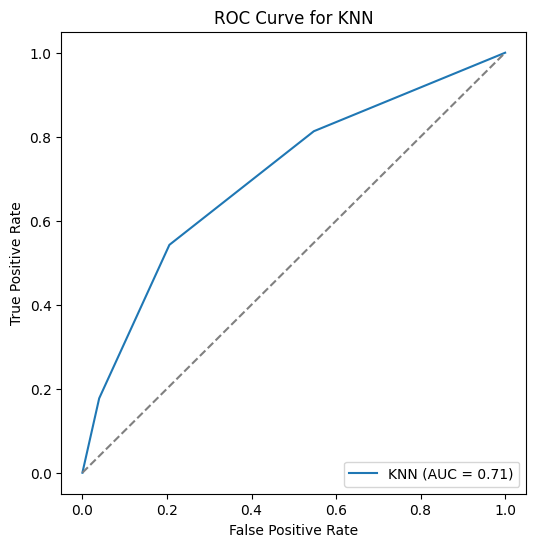

KNN TESTING TIME: 12042.21 ms


In [10]:
knn_model = Pipeline([
    ('scale', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=3))
    ])

knn_train_time, _, _ = train_model(knn_model, X_train, y_train)
print(f"KNN TRAINING TIME: {knn_train_time:.2f} ms")

knn_test_time = test_model(knn_model, "KNN")
print(f"KNN TESTING TIME: {knn_test_time:.2f} ms")

### Logistic Regression

LOGISTIC REGRESSION TRAINING TIME: 349.82 ms

--- Logistic Regression PREDICTION RESULTS ---
Confusion Matrix:
 [[45538  2203]
 [24465  2341]]
F1 Score:  0.14934609250398725
Recall:  0.08733119450869209
Precision:  0.5151848591549296
Accuracy:  0.6422659530229251


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


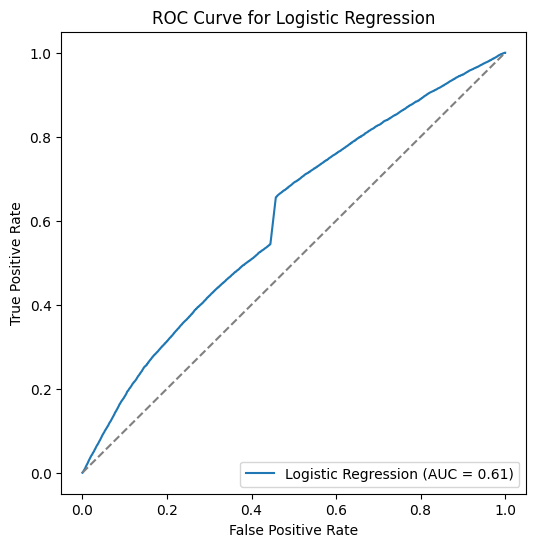

LOGISTIC REGRESSION TESTING TIME: 4.00 ms


In [ ]:
log_reg_model = Pipeline([
    ('scale', StandardScaler()),
    ('log_reg', LogisticRegression(max_iter=10000, random_state=42, verbose=True))
    ])

log_reg_train_time, _, _ = train_model(log_reg_model, X_train, y_train)
print(f"LOGISTIC REGRESSION TRAINING TIME: {log_reg_train_time:.2f} ms")

log_reg_test_time = test_model(log_reg_model, "Logistic Regression")
print(f"LOGISTIC REGRESSION TESTING TIME: {log_reg_test_time:.2f} ms")

### Random Forest

RANDOM FOREST TRAINING TIME: 2371.01 ms

--- Random Forest PREDICTION RESULTS ---
Confusion Matrix:
 [[45316  2425]
 [22554  4252]]
F1 Score:  0.2539796314547681
Recall:  0.15862120420801312
Precision:  0.6368129399430882
Accuracy:  0.6649228003809677


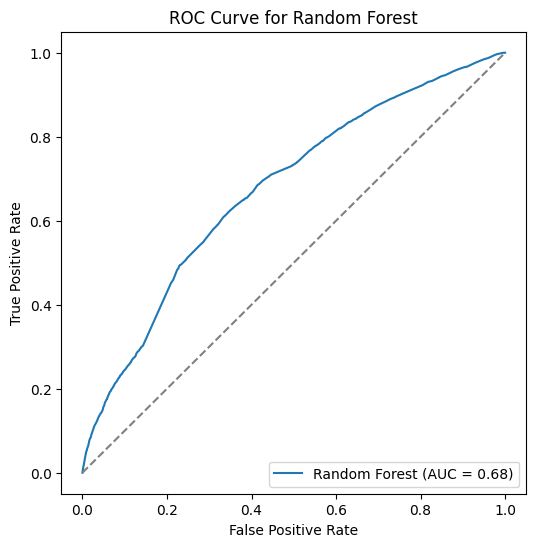

RANDOM FOREST TESTING TIME: 13.50 ms


In [ ]:
# Create a grid search cv for random forest that optimizes n_estimators and max_depth
param_grid = {  
    'n_estimators': [5, 10, 20],
    'max_depth': [5, 10, 20]
}

random_forest = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(random_forest, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

random_forest_model = RandomForestClassifier(**best_params, random_state=42)

random_forest_model_train_time, _, _ = train_model(random_forest_model, X_train, y_train)
print(f"RANDOM FOREST TRAINING TIME: {random_forest_model_train_time:.2f} ms")

random_forest_test_time = test_model(random_forest_model, "Random Forest")
print(f"RANDOM FOREST TESTING TIME: {random_forest_test_time:.2f} ms")

### XGBoost

[23:33:39] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (670922, 7, 4696454).
XGBOOST TRAINING TIME: 290.49 ms

--- XGBoost PREDICTION RESULTS ---
Confusion Matrix:
 [[45101  2640]
 [19525  7281]]
F1 Score:  0.39649304326517276
Recall:  0.2716182944116989
Precision:  0.7338977925612338
Accuracy:  0.7026707982883281


c:\Users\david\GitHub\ds3000a-project-group10\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:33:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


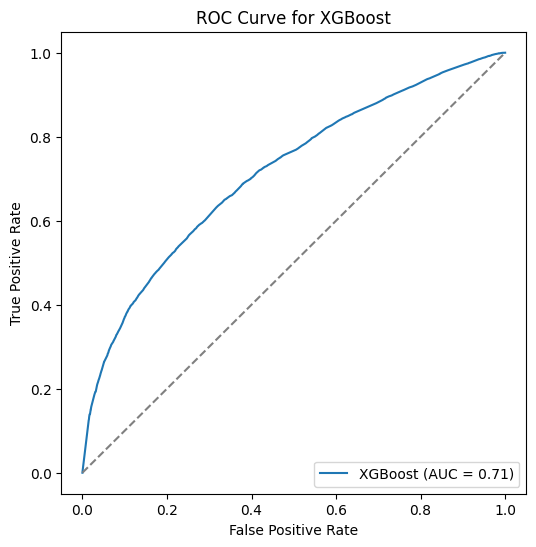

XGBOOST TESTING TIME: 5.00 ms


In [ ]:
from xgboost import XGBClassifier

# create a grid search cv for the XGBoost classifier that optimizes n_estimators and max_depth
param_grid = {
    'n_estimators': [5, 10, 20],
    'max_depth': [5, 10, 20]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, verbosity=2)
grid_search = GridSearchCV(xgb, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

xgb_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42, verbosity=2)
xgb_model_train_time, _, _ = train_model(xgb_model, X_train, y_train)
print(f"XGBOOST TRAINING TIME: {xgb_model_train_time:.2f} ms") 

xgb_test_time = test_model(xgb_model, "XGBoost")
print(f"XGBOOST TESTING TIME: {xgb_test_time:.2f} ms")

### MLP

Iteration 1, loss = 0.60264478
Iteration 2, loss = 0.58530353
Iteration 3, loss = 0.57900632
Iteration 4, loss = 0.57503946
Iteration 5, loss = 0.57198582
Iteration 6, loss = 0.56981001
Iteration 7, loss = 0.56791024
Iteration 8, loss = 0.56678564
Iteration 9, loss = 0.56555402
Iteration 10, loss = 0.56473106
Iteration 11, loss = 0.56393973
Iteration 12, loss = 0.56310832
Iteration 13, loss = 0.56250974
Iteration 14, loss = 0.56193235
Iteration 15, loss = 0.56130544
Iteration 16, loss = 0.56069396
Iteration 17, loss = 0.56031273
Iteration 18, loss = 0.55987130
Iteration 19, loss = 0.55932300
Iteration 20, loss = 0.55907806
Iteration 21, loss = 0.55864211
Iteration 22, loss = 0.55814107
Iteration 23, loss = 0.55785618
Iteration 24, loss = 0.55771151
Iteration 25, loss = 0.55737003
Iteration 26, loss = 0.55719334
Iteration 27, loss = 0.55690736
Iteration 28, loss = 0.55679954
Iteration 29, loss = 0.55684255
Iteration 30, loss = 0.55649845
Iteration 31, loss = 0.55617718
Iteration 32, los

c:\Users\david\GitHub\ds3000a-project-group10\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


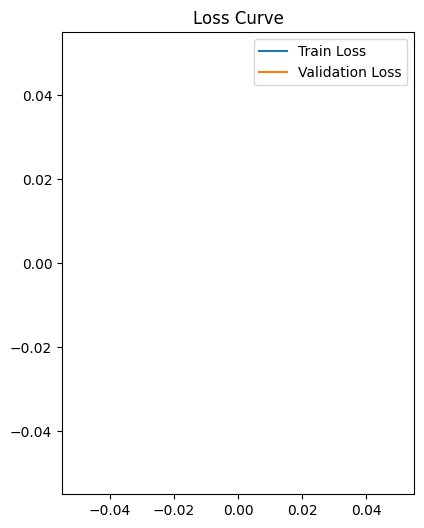


--- MLP PREDICTION RESULTS ---
Confusion Matrix:
 [[41842  5899]
 [14483 12323]]
F1 Score:  0.5473483166030025
Recall:  0.4597105125718123
Precision:  0.6762704423224674
Accuracy:  0.7265885951144915


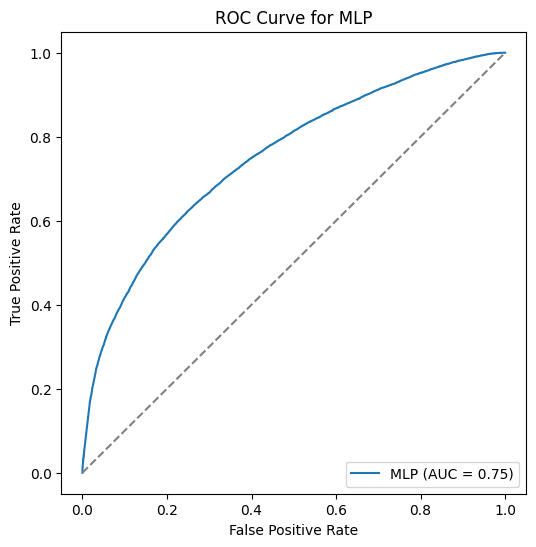

MLP TESTING TIME: 182.50 ms


In [ ]:
from sklearn.neural_network import MLPClassifier

X_train_nn, X_val, y_train_nn, y_val = train_test_split(
    X_train, y_train, test_size=0.222, random_state=42 # 0.222 * 0.9 = 0.2
)

mlp_model = Pipeline([
    ('scale', StandardScaler()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(50, 100),
                                 activation='tanh',
                                 solver='sgd',
                                 learning_rate_init=0.1,
                                 max_iter=10000,
                                 warm_start=True,
                                 verbose=True,
                                 random_state=42)
    )
])

mlp_train_time, mlp_train_losses, mlp_validation_losses = train_model(mlp_model, X_train_nn, y_train_nn, X_val, y_val)
print(f"MLP TRAINING TIME: {mlp_train_time:.2f} ms")

# Plotting learning curves for training and validation
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(mlp_train_losses, label='Train Loss')
plt.plot(mlp_validation_losses, label='Validation Loss')
plt.legend()
plt.title("Loss Curve")

plt.show()

mlp_test_time = test_model(mlp_model, "MLP")
print(f"MLP TESTING TIME: {mlp_test_time:.2f} ms")